In [61]:
# importing necessary variables

import requests
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from itertools import combinations
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [93]:
# designing helper functions: "imdb_helper_functions.py"

def get_soup(link, get_description=0, url='https://www.imdb.com/'):
    headers = {'Accept-Language': 'en',
               'X-FORWARDED-FOR': '2.21.184.0'}
    if link[1] == 't':
        if get_description == 1:
            response = requests.get(url + link, headers=headers)
        else:
            response = requests.get(url + link + '/fullcredits', headers=headers)
    elif link[1] == 'n':
        response = requests.get(url + link, headers=headers)
        
    assert response.status_code == 200
    soup = BeautifulSoup(response.text)
    return soup


def actor_search_func(cast_page_soup, num_of_actors_limit=None):
    actors_list = []
    actors_links = set()
    actor_table = cast_page_soup.find_all('table', attrs={'class': 'cast_list'})[0]
    for row in actor_table:
        if len(row) > 1:
            row_data = (row.find('img')['alt'], row.find('a')['href'])
            actors_list.append(row_data)
            actors_links.add(row.find('a')['href'])

            if num_of_actors_limit:
                num_of_actors_limit -= 1
            if num_of_actors_limit == 0:
                break

    return actors_list, actors_links


def movie_search_func(actor_page_soup, num_of_movies_limit=None):
    movies_of_actor = []
    movies_of_actor_set = set()
    if actor_page_soup.find('div', attrs={'id': 'filmo-head-actor'}) is None:
        movies_table = actor_page_soup.find('div', attrs={'id': 'filmo-head-actress'})
    else:
        movies_table = actor_page_soup.find('div', attrs={'id': 'filmo-head-actor'})

    if movies_table is not None:
        movies_table = movies_table.next_sibling.next_sibling

        for row in movies_table:
            if (len(row) > 1) \
            and (row.find('a', attrs={'class': 'in_production'}) is None) \
            and (len(row.find('a').parent.next_sibling) == 1):
                row_data = row.find('a').text, row.find('a')['href']
                movies_of_actor.append(row_data)
                movies_of_actor_set.add(row.find('a')['href'])

                if num_of_movies_limit:
                    num_of_movies_limit -= 1
                if num_of_movies_limit == 0:
                    break

    return movies_of_actor, movies_of_actor_set


def search_func(actor_start_url, actor_end_url, current_distance, actor_distances, \
                actor_key, num_of_actors_limit=None, num_of_movies_limit=None):

    print('Current distance', current_distance, '--- Actor link:', actor_start_url)

    if actor_start_url in seen_actors.keys():
        movie_list = seen_actors[actor_start_url][0]
        movie_links = seen_actors[actor_start_url][1]
    else:
        actor_soup = get_soup(actor_start_url[:-1])
        movie_list, movie_links = movie_search_func(actor_soup, num_of_movies_limit)
        seen_actors.setdefault(actor_start_url, [movie_list, movie_links])

    actor_distances[actor_key].setdefault(current_distance, set())
    for movie in movie_list:
        if movie[1] in seen_movies.keys():
            actors_list = seen_movies[movie[1]][0]
            actors_links = seen_movies[movie[1]][1]
        else:
            movie_soup = get_soup(movie[1][:-1])
            actors_list, actors_links = actor_search_func(movie_soup, num_of_actors_limit)
            seen_movies.setdefault(movie[1], [actors_list, actors_links])

        actor_distances[actor_key][current_distance] = \
            actor_distances[actor_key][current_distance].union(actors_links)

    if actor_end_url in actor_distances[actor_key][current_distance]:
        return current_distance
    return 'na'


def read_files(seen_df):
    seen = seen_df.to_dict()
    for key, value in seen.items():
        seen[key] = [list(value[0]), set()]
        for v in seen[key][0]:
            seen[key][1].add(value[1])
            

def get_actors_distance_graph(test_actors_list):
    actor_distance_graph = nx.Graph()
    test_actors_list_graph = []

    for i in test_actors_list:
        test_actors_list_graph.append(i[0])
    
    actor_distance_graph.add_nodes_from(test_actors_list_graph)
    return actor_distance_graph
    
            
def plot_graph(distances, test_actors_list):
    
    distances_graph = get_actors_distance_graph(test_actors_list)
    edge_labels = {}
    
    for d in distances:
        edge_coef = 1 / d[2]
        distances_graph.add_edge(d[0], d[1], color=[1-np.sqrt(edge_coef), 0, 0], weight=min(1.25, edge_coef**2 * 3.5))
        edge_labels.setdefault((d[0], d[1]), d[2])
    
    edges = distances_graph.edges()
    colors = [distances_graph[u][v]['color'] for u,v in edges]
    weights = [distances_graph[u][v]['weight'] for u,v in edges]

    pos = nx.circular_layout(distances_graph)
    print('Actor distances graph.')
    nx.draw(distances_graph, pos=pos, with_labels=True, edge_color=colors, width=weights)
    nx.draw_networkx_edge_labels(distances_graph, pos=pos, edge_labels=edge_labels)

def plot_graphs_by_distance(distances, distance, test_actors_list):

    distance_graph = get_actors_distance_graph(test_actors_list)
    edge_labels = {}
    
    for d in distances:
        if d[2] == distance:
            edge_coef = 1 / d[2]
            distance_graph.add_edge(d[0], d[1], color=[1-np.sqrt(edge_coef), 0, 0], weight=min(1.25, edge_coef**2 * 3.5))
            edge_labels.setdefault((d[0], d[1]), d[2])
    
    edges = distance_graph.edges()
    colors = [distance_graph[u][v]['color'] for u,v in edges]
    weights = [distance_graph[u][v]['weight'] for u,v in edges]

    pos = nx.circular_layout(distance_graph)
    nx.draw(distance_graph, pos=pos, with_labels=True, edge_color=colors, width=weights)
    nx.draw_networkx_edge_labels(distance_graph, pos=pos, edge_labels=edge_labels)
    plt.figure()
    
    
def save_files():
    seen_movies_df = pd.DataFrame()
    seen_movies_df = seen_movies_df.from_dict(seen_movies)
    seen_movies_df.to_csv('seen_movies_df.csv', sep='$')
    
    seen_actors_df = pd.DataFrame()
    seen_actors_df = seen_actors_df.from_dict(seen_actors)
    seen_actors_df.to_csv('seen_actors_df.csv', sep='$')
    
    actor_distances_df = pd.DataFrame()
    actor_distances_df = actor_distances_df.from_dict(actor_distances)
    actor_distances_df.to_csv('actor_distances_df.csv', sep='$')
    

def get_movie_descriptions_from_file(filename):
    all_descriptions = ''
    with open(('mdescription_' + str(actor[0]) + '.csv'), 'r', encoding="utf-8") as f:
        movie_descriptions = f.readlines()
    
    movie_descriptions = pd.Series(movie_descriptions)
    print(filename[13:-4], 'wordcloud')
    plot_cloud(movie_descriptions)
    return movie_descriptions
    
def plot_cloud(movie_descriptions):
    stopwords = set()
    stopwords.update(['a', 'the', 'and', 'of', 'to', 'his', 'with', 'by', 'they', 'be', \
                      'that', 'for', 'in', 'an', 'from', 'he', 'she', 'as', 'being', 'into', \
                      'her', 'i', 'only', 'it', 'when', 'through', 'has', 'out', 'about', 'after', \
                      'up', 'before', 'but', 'on', 'must', 'who', 'are', 'is', 'was', 'were', \
                      'their', 'get', 'one', 'two', 'three', 'at', 'them', 'than', 'all', 'where', \
                      'or', 'read', 'off', 'this', 'gets', 'while', 'four', 'have', 'himself', 'herself', \
                      'him', 'other'
                     ])
    
    descriptions_text = movie_descriptions.str.cat()
    actor_cloud = WordCloud(stopwords=stopwords, background_color="white").generate(descriptions_text)
    plt.imshow(actor_cloud, interpolation='gaussian')
    plt.show()


In [71]:
# designing main function: "imdb_code.py"

def get_actors_by_movie_soup(cast_page_soup, num_of_actors_limit=None):
    actors_list, actor_links = actor_search_func(cast_page_soup, num_of_actors_limit=None)
    return actors_list


def get_movies_by_actor_soup(actor_page_soup, num_of_movies_limit=None):
    movie_list, movie_list_links = movie_search_func(actor_page_soup, num_of_movies_limit)
    return movie_list


def get_movie_distance(actor_start_url, actor_end_url,
        num_of_actors_limit=None, num_of_movies_limit=None):

    if actor_start_url[-16] == '/':
        actor_start_url = actor_start_url[-16:]
    elif actor_start_url[-17] == '/':
        actor_start_url = actor_start_url[-17:]
    elif actor_start_url[-18] == '/':
        actor_start_url = actor_start_url[-18:]

    if actor_end_url[-16] == '/':
        actor_end_url = actor_end_url[-16:]
    elif actor_end_url[-17] == '/':
        actor_end_url = actor_end_url[-17:]
    elif actor_end_url[-18] == '/':
        actor_end_url = actor_end_url[-18:]

    actor_name = get_soup(actor_start_url).find('span', attrs={'class': 'itemprop'}).text
    actor_key = tuple((actor_name, actor_start_url))
    actor_distances.setdefault(actor_key, {})
    
    for d in range(1, search_dist):
        try:
            if actor_end_url in actor_distances[actor_key][d]:
                return d
        except KeyError:
            pass
    
    movie_distance = search_func(actor_start_url, actor_end_url, 1, actor_distances, \
                                 actor_key, num_of_actors_limit, num_of_movies_limit)
    if movie_distance == 1:
        return movie_distance

    for current_distance in range(2, search_dist+1):
        for actor in actor_distances[actor_key][current_distance-1]:
            movie_distance = search_func(actor, actor_end_url, current_distance, actor_distances, \
                                         actor_key, num_of_actors_limit, num_of_movies_limit)
            if isinstance(movie_distance, int):
                return movie_distance
    return 'Distance not found'
    
    
def get_movie_descriptions_by_actor_soup(actor_page_soup):
    movie_descriptions, all_descriptions = [], ''
    
    movies_of_actor, movies_of_actor_set = movie_search_func(actor_page_soup)
    actor_name = actor_page_soup.find('span', attrs={'class': 'itemprop'}).text
    print('Getting descriptions...')
    
    for movie in movies_of_actor:
        movie_soup = get_soup(movie[1][:-1], get_description=1)
        movie_description = movie_soup.find('span', \
                                            attrs={'class': 'GenresAndPlot__TextContainerBreakpointXS_TO_M-sc-cum89p-0'}).text
        movie_descriptions.append(str(movie_description).lower())
    
    for description in movie_descriptions:
        all_descriptions += description
    with open(('mdescription_' + str(actor_name) + '.txt'), 'w', encoding="utf-8") as f:
        f.write(all_descriptions)

    movie_descriptions = pd.Series(movie_descriptions)
    print('All descriptions have been extracted and saved.\n', actor_name, 'wordcloud:')
    print(str(actor_name), 'wordcloud:')
    plot_cloud(movie_descriptions)
    return movie_descriptions # your code here


In [72]:
# declaring variables

actor_url = 'https://www.imdb.com/name'
movie_url = 'https://www.imdb.com/title'
actor_distances, seen_movies, seen_actors = {}, {}, {}
distances = []
search_dist = 3
test_actors_list = [('Dwayne Johnson', '/name/nm0425005/'),
                    ('Chris Hemsworth', '/name/nm1165110/'),
                    ('Robert Downey Jr.', '/name/nm0000375/'),
                    ('Akshay Kumar', '/name/nm0474774/'),
                    ('Jackie Chan', '/name/nm0000329/'),
                    ('Bradley Cooper', '/name/nm0177896/'),
                    ('Adam Sandler', '/name/nm0001191/'),
                    ('Scarlett Johansson', '/name/nm0424060/'),
                    ('Sofía Vergara', '/name/nm0005527/'),
                    ('Chris Evans', '/name/nm0262635/')]

actor_check_list = list(combinations(test_actors_list, 2))

In [75]:
distances = []        
distances_list = pd.read_csv('actor_distances_pairwise.csv', sep='$', index_col=0).values.tolist()
for element in distances_list:
    distances.append(tuple(element))

In [ ]:
# finding movie distances for 10 top-paid actors (limited by 3 movies and 3 actors, due to slow internet connection)

for pair in actor_check_list:
    print('Checking:', pair[0][0], ' --- ', pair[1][0])
    dist = get_movie_distance(pair[0][1], pair[1][1], 5, 5)
    print(dist)
    if dist != 'Distance not found':
        distances.append(tuple((pair[0][0], pair[1][0], int(dist))))

Actor distances graph.


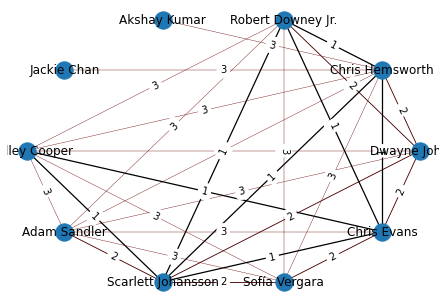

In [94]:
# plotting distance graphs for 10 top-paid actors
plot_graph(distances, test_actors_list)

Actor distances graph for each distance.


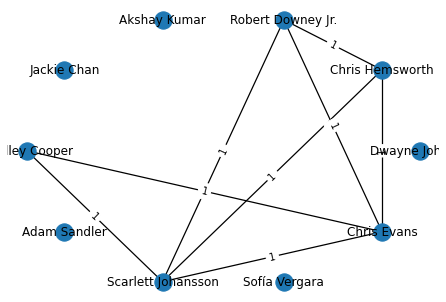

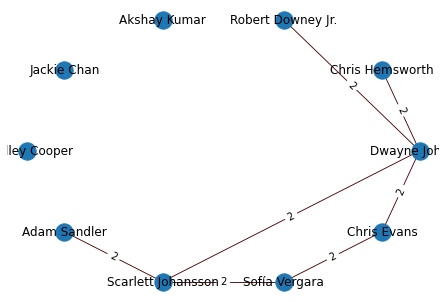

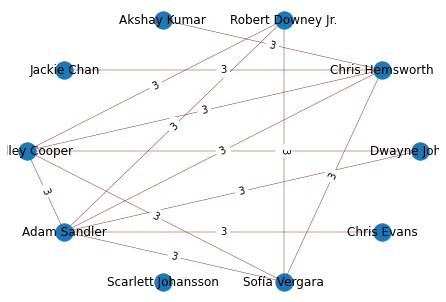

<Figure size 432x288 with 0 Axes>

In [95]:
print('Actor distances graph for each distance.')
for distance in range(1, search_dist+1):
    plot_graphs_by_distance(distances, distance, test_actors_list)

In [9]:
distances_df = pd.DataFrame(distances)
distances_df.to_csv('actor_distances_pairwise.csv', sep='$')

Dwayne Johnson wordcloud


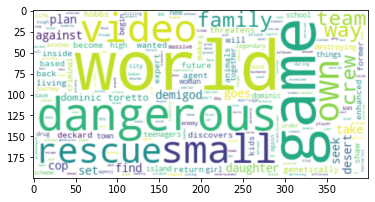

Chris Hemsworth wordcloud


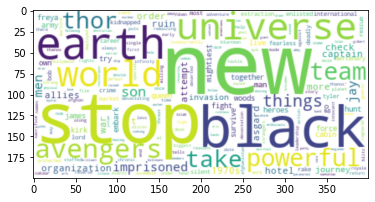

Robert Downey Jr. wordcloud


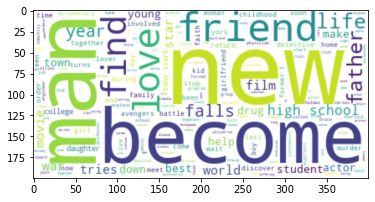

Akshay Kumar wordcloud


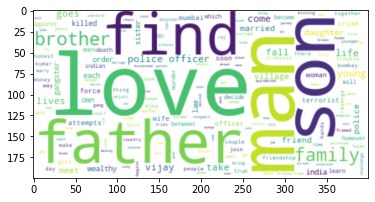

Jackie Chan wordcloud


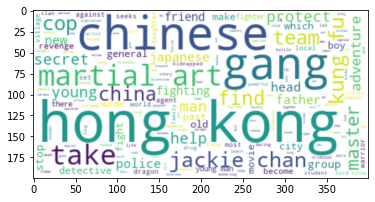

Bradley Cooper wordcloud


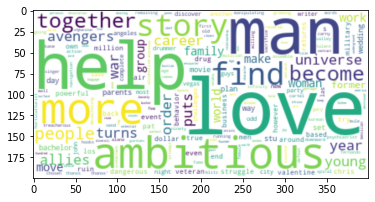

Adam Sandler wordcloud


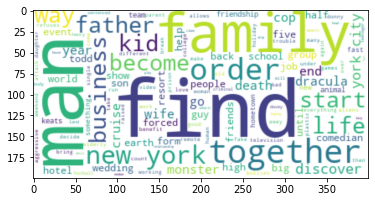

Scarlett Johansson wordcloud


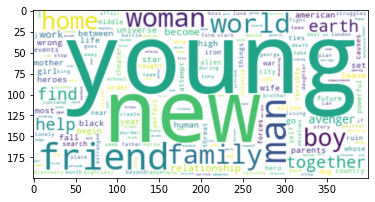

Sofía Vergara wordcloud


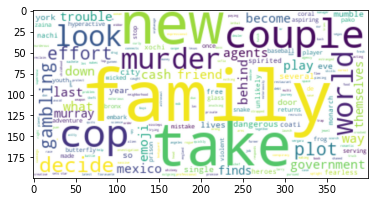

Chris Evans wordcloud


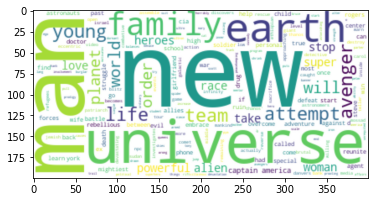

In [11]:
# plotting wordclouds for 10 top-paid actors

for actor in test_actors_list:
    actor_soup = get_soup(actor[1])
    movie_descriptions = get_movie_descriptions_by_actor_soup(actor_soup)

Dwayne Johnson wordcloud


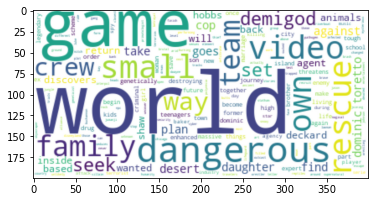

Chris Hemsworth wordcloud


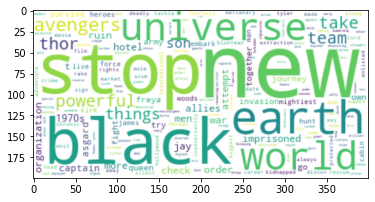

Robert Downey Jr. wordcloud


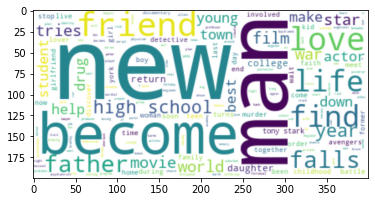

Akshay Kumar wordcloud


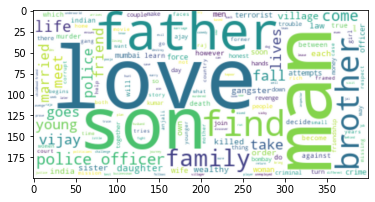

Jackie Chan wordcloud


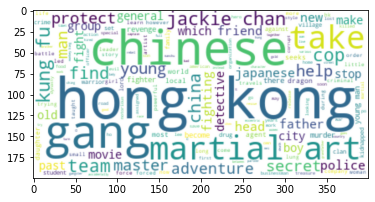

Bradley Cooper wordcloud


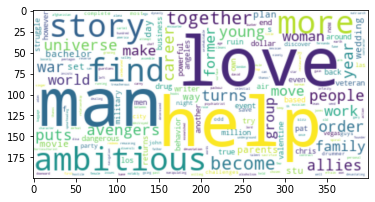

Adam Sandler wordcloud


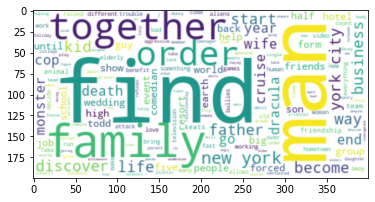

Scarlett Johansson wordcloud


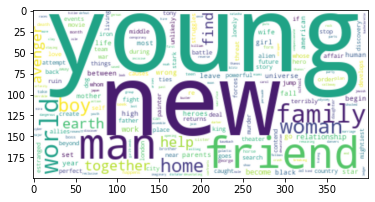

Sofía Vergara wordcloud


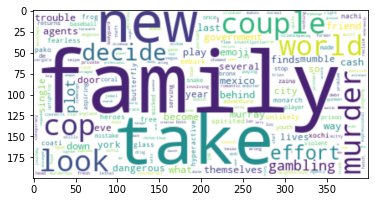

Chris Evans wordcloud


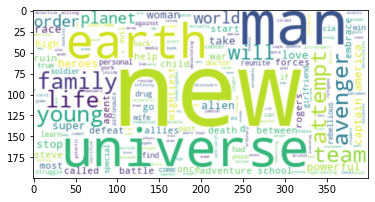

In [69]:
# plotting wordclouds for 10 top-paid actors from the file

for actor in test_actors_list:
    get_movie_descriptions_from_file(('mdescription_' + str(actor[0]) + '.txt'))

In [244]:
# checking get_movie_distance function for two random actors

get_movie_distance('https://www.imdb.com/name/nm0000093/', '/name/nm3053338/', 3, 3)

Current distance 1 --- Actor link: /name/nm0000093/


1